# BPNet Hits Peak Set x Motif

Motifs scores for each peak set based on BPNet hits. 

Inputs:
1. BPNet motif hits
2. Peak sets
3. Motif group metadata (e.g. Vierstra motif clusters)

In [1]:
library(rtracklayer)
library(matrixStats)
library(reshape2)
library(ggplot2)
library(scales)
library(patchwork)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vecto

## Load Data

### BPNet Motif Hits

In [5]:
bpnet_motif_hits = read.table("../../analysis/20211007_motif_consolidation/consolidated/20210820_chrombpnet_lite/motifs.importance.thresholded.bed", sep='\t')
colnames(bpnet_motif_hits) = c('chr', 'start', 'end', 'name', 'score', 'strand', 'seq')
bpnet_motif_hits = GRanges(bpnet_motif_hits)
head(bpnet_motif_hits)

GRanges object with 6 ranges and 3 metadata columns:
      seqnames      ranges strand |                  name         score
         <Rle>   <IRanges>  <Rle> |              <factor>     <numeric>
  [1]     chr1 11339-11358      - |         CTCF_MA0139.1 10.2012016598
  [2]     chr1 11342-11357      + |  ZIC3_HUMAN.H11MO.0.B 9.72383539099
  [3]     chr1 13497-13514      + |  NFIC_HUMAN.H11MO.0.A 9.01997757378
  [4]     chr1 15464-15478      - | MEF2D_MOUSE.H11MO.0.A 7.37016971345
  [5]     chr1 15626-15645      - |         CTCF_MA0139.1 9.07066150329
  [6]     chr1 21575-21597      - |   SP2_HUMAN.H11MO.0.A 8.28216872218
                         seq
                    <factor>
  [1]    GCACGCCGCCTGCTGGCAG
  [2]        CGCCGCCTGCTGGCA
  [3]      CCTGGCGCTGTGCCCTT
  [4]         CTCTAAAAATATCT
  [5]    TGAGGACCTCTGGTGGCGG
  [6] TGCCCTGCCCCACACCCTGCCA
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

### Peak Sets

In [6]:
peak_sets = list()
NUM_PEAK_SETS = 20
PEAK_SET_PATH = "../../analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/"

for (i in seq(NUM_PEAK_SETS)) {
    peak_sets[[i]] = import(sprintf("%s/idx%d.bed", PEAK_SET_PATH, i))
}

In [7]:
unlist(lapply(peak_sets, length))

[1] 39006 51449 21137 37309 28388 30214 23500 27541  6907 18844 17471 13119
[13] 21090 15179 23696 32573 37539 19750 32863 28260

### Motif Group Metadata

In [8]:
motifs = read.table("../../../resources/Vierstra/motifs.tsv", 
                    header=T,
                   stringsAsFactors=F)
rownames(motifs) = motifs$Motif
motifs$Motif = NULL
dim(motifs)
head(motifs)

[1] 2174    8

,Cluster_ID,Database,Consensus,Relative_orientation,Width,Left_offset,Right_offset,Gene
,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
LHX6_homeodomain_3,1,Taipale_Cell_2013,TGATTGCAATCA,+,12,0,0,LHX6
Lhx8.mouse_homeodomain_3,1,Taipale_Cell_2013,TGATTGCAATTA,-,12,0,0,Lhx8
LHX2_MOUSE.H11MO.0.A,2,HOCOMOCO_v11,ACTAATTAAC,-,10,7,9,LHX2
LHX2_HUMAN.H11MO.0.A,2,HOCOMOCO_v11,AACTAATTAAAA,-,12,6,8,LHX2
LHX3_MOUSE.H11MO.0.C,2,HOCOMOCO_v11,TTAATTAGC,-,9,8,9,LHX3
NOBOX_HUMAN.H11MO.0.C,2,HOCOMOCO_v11,ACCAATTAG,-,9,7,10,NOBOX


In [9]:
motif_archetypes = read.table("../../../resources/Vierstra/archetypes.tsv", 
                              header=T,
                             stringsAsFactors=F)
motif_archetypes = motif_archetypes[order(motif_archetypes$Cluster_ID), ]
rownames(motif_archetypes) = motif_archetypes$Cluster_ID
dim(motif_archetypes)
head(motif_archetypes)

[1] 286   8

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
2,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
3,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
4,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
5,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
6,6,HD/6,homeodomain,BARHL2_MA0635.1,18,1,16,11


## Process

### Make Counts Matrix

In [194]:
peak_x_motif_counts = matrix(0, nrow=NUM_PEAK_SETS, 
                                 ncol=length(unique(bpnet_motif_hits$name)))
rownames(peak_x_motif_counts) = seq(NUM_PEAK_SETS)
colnames(peak_x_motif_counts) = unique(bpnet_motif_hits$name)

# count one motif only once per peak
peak_x_motif_counts_unique = matrix(0, nrow=NUM_PEAK_SETS, 
                                 ncol=length(unique(bpnet_motif_hits$name)))
rownames(peak_x_motif_counts_unique) = seq(NUM_PEAK_SETS)
colnames(peak_x_motif_counts_unique) = unique(bpnet_motif_hits$name)

In [382]:
for (i in seq(NUM_PEAK_SETS)) {
    cur_peak_set = peak_sets[[i]]
    NUM_PEAKS[[i]] = length(cur_peak_set)
    
    
    overlaps = findOverlaps(bpnet_motif_hits, cur_peak_set, type='within')
        
    # allows counting multiple hits per peak
    all_hits = bpnet_motif_hits[queryHits(overlaps)]$name
    
    cur_motif_counts = table(all_hits)    
    peak_x_motif_counts[i, names(cur_motif_counts)] = cur_motif_counts
    
        # max one hit per peak
    all_hits = unique(data.frame(m=bpnet_motif_hits[queryHits(overlaps)]$name,
           p=as.character(cur_peak_set[subjectHits(overlaps)])))$m
    cur_motif_counts = table(all_hits)    
    peak_x_motif_counts_unique[i, names(cur_motif_counts)] = cur_motif_counts

}

### Normalize Matrix

In [604]:
# filter
MIN_TOTAL_HITS = 1000
peak_x_motif_norm = peak_x_motif_counts[, colSums(peak_x_motif_counts)>MIN_TOTAL_HITS]

# row norm
peak_x_motif_norm = peak_x_motif_norm/rowSums(peak_x_motif_norm)
peak_x_motif_norm[peak_x_motif_norm < 0.01] = 0

# col norm by total number of peaks in peakset
# may show higher counts for peak sets part of multiple cell states 
# which would as a result have more called motifs
# peak_x_motif_norm = t(t(peak_x_motif_norm)/unlist(NUM_PEAKS[rownames(peak_x_motif_counts)]))

# column norm to 0-1
peak_x_motif_norm = t(t(peak_x_motif_norm) - colMins(peak_x_motif_norm))
peak_x_motif_norm = t(t(peak_x_motif_norm)/colMaxs(peak_x_motif_norm))

peak_x_motif_norm = peak_x_motif_norm[, colSums(is.na(peak_x_motif_norm))==0]

head(peak_x_motif_norm)

,CTCF_MA0139.1,ZIC3_HUMAN.H11MO.0.B,NFIC_HUMAN.H11MO.0.A,SP2_HUMAN.H11MO.0.A,KLF3_HUMAN.H11MO.0.B,EGR2_MOUSE.H11MO.0.A,ETS1_MOUSE.H11MO.0.A,TWST1_MOUSE.H11MO.0.B,ZN143_MOUSE.H11MO.0.A,POU3F2_MA0787.1,⋯,SOX15_MA1152.1,NFYB_HUMAN.H11MO.0.A,RFX2_MOUSE.H11MO.0.A,REST_MA0138.2,COE1_HUMAN.H11MO.0.A,FOXC2_MA0846.1,IRF1_MA0050.2,NFKB1_HUMAN.H11MO.1.B,SIX1_HUMAN.H11MO.0.A,GRHL1_CP2_1
1,0.10115822,0.2197850,0.9274039,0.068728887,0.10595146,0.1790951,0.70669458,0.8779024,0.0000000,0.1280053,⋯,0.0000000,0,0.6484765,0,0.2953490,0.7532318,0.6477044,0.5123711,0.6987654,0
2,0.19709391,0.2667422,1.0000000,0.001392601,0.00000000,0.0000000,0.41851113,1.0000000,0.0000000,0.1002416,⋯,0.0000000,0,0.6796920,0,0.2862284,1.0000000,1.0000000,0.3543351,0.7107029,0
3,0.09890573,0.2167280,0.8086945,0.267191604,0.35946517,0.3999808,0.76976807,0.6101641,0.0000000,0.1215237,⋯,0.1794072,0,0.6488147,0,0.3560542,0.3413320,0.0000000,0.4452648,0.4747352,0
4,0.07299551,0.1533649,0.7261217,0.000000000,0.01798431,0.2072605,1.00000000,0.8910843,0.0000000,0.1203017,⋯,0.0000000,0,0.0000000,0,0.3808980,0.8136859,0.6107861,1.0000000,0.8806386,0
5,0.14096443,0.1579508,0.4190564,0.573130434,1.00000000,0.8258838,0.39776873,0.0000000,0.0000000,0.0000000,⋯,0.0000000,0,0.0000000,0,0.4145535,0.0000000,0.0000000,0.4032558,0.0000000,0
6,0.00000000,0.0000000,0.0000000,0.254264297,0.72615165,1.0000000,0.01512709,0.0000000,0.3726683,0.4629757,⋯,1.0000000,0,0.0000000,0,0.0000000,0.0000000,0.0000000,0.6324387,0.0000000,0


In [605]:
# enrichment 
# peak_x_motif_norm = peak_x_motif_counts/unlist(lapply(peak_sets, length))
# peak_x_motif_norm = t(t(peak_x_motif_norm)/(colSums(peak_x_motif_counts)/sum(unlist(lapply(peak_sets, length)))))
# peak_x_motif_norm

In [606]:
dim(peak_x_motif_counts)

[1] 20 30

In [607]:
dim(peak_x_motif_norm)

[1] 20 29

In [608]:
all(colMins(peak_x_motif_norm)==0)
all(colMaxs(peak_x_motif_norm)==1)

[1] TRUE

[1] TRUE

In [609]:
all(colnames(peak_x_motif_norm) %in% rownames(motifs))

[1] TRUE

In [610]:
to_plot_df = melt(peak_x_motif_norm)

to_plot_df$peak_set_idx = factor(to_plot_df$Var1, levels=rev(sort(unique(to_plot_df$Var1))))
to_plot_df$score = to_plot_df$value
to_plot_df$TF = as.character(to_plot_df$Var2)

df_tf_fam = factor(motif_archetypes[motifs[to_plot_df$TF, "Cluster_ID"], "Name"])
to_plot_df$TF_family = as.character(df_tf_fam)

In [611]:
head(to_plot_df)

,Var1,Var2,value,peak_set_idx,score,TF,TF_family
,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>,<chr>
1,1,CTCF_MA0139.1,0.10115822,1,0.10115822,CTCF_MA0139.1,CTCF
2,2,CTCF_MA0139.1,0.19709391,2,0.19709391,CTCF_MA0139.1,CTCF
3,3,CTCF_MA0139.1,0.09890573,3,0.09890573,CTCF_MA0139.1,CTCF
4,4,CTCF_MA0139.1,0.07299551,4,0.07299551,CTCF_MA0139.1,CTCF
5,5,CTCF_MA0139.1,0.14096443,5,0.14096443,CTCF_MA0139.1,CTCF
6,6,CTCF_MA0139.1,0.00000000,6,0.00000000,CTCF_MA0139.1,CTCF


In [612]:
# add frac peaks with motif counts
frac_peak_x_motif = melt((peak_x_motif_counts_unique/unlist(lapply(peak_sets, length)))[, colnames(peak_x_motif_norm)])

stopifnot(all(frac_peak_x_motif$Var1==to_plot_df$Var1))
stopifnot(all(frac_peak_x_motif$Var2==to_plot_df$Var2))

to_plot_df$frac = frac_peak_x_motif$value

In [613]:
# total counts of motifs
tot_motif_count = colSums(peak_x_motif_counts)

In [614]:
dim(to_plot_df)

[1] 580   8

### Remove Correlated TFs

In [615]:
# remove highly correlated TFs per family
# https://stackoverflow.com/questions/18275639/remove-highly-correlated-variables

# REMOVE_ABOVE = 0.9

# keep_TFs = c()
# for (x in unique(to_plot_df$TF_family)) {
#     cur_tf_df = to_plot_df[to_plot_df$TF_family==x, c("score", "TF", "peak_set_idx")]
#     if (length(unique(cur_tf_df$TF))==1) {
#         keep_TFs = c(keep_TFs, unique(cur_tf_df$TF))
#         next 
#     }
    
#     # make TF x sample matrix 
#     tf_sample_matrix = matrix(0, nrow=length(unique(cur_tf_df$TF)), ncol=length(unique(cur_tf_df$peak_set_idx)))
#     rownames(tf_sample_matrix) = unique(cur_tf_df$TF)
#     colnames(tf_sample_matrix) = unique(cur_tf_df$sample)
    
#     for (i in seq(1, dim(cur_tf_df)[1])) {
#         tf_sample_matrix[cur_tf_df[i, "TF"], cur_tf_df[i, "peak_set_idx"]] = cur_tf_df[i, "score"]
#     }
    
#     # reorder TFs to bring those with most raw count up
#     tf_sample_matrix = tf_sample_matrix[rev(order(tot_motif_count[rownames(tf_sample_matrix)])), ]
    
#     # remove those with high correlation to another
#     tf_cor = cor(t(tf_sample_matrix), method='spearman')
#     tf_cor[upper.tri(tf_cor)] <- 0
#     diag(tf_cor) <- 0
#     keep_TFs = c(keep_TFs, 
#                  rownames(tf_cor)[!apply(tf_cor,1,function(x) any(x > REMOVE_ABOVE))])

# }

# length(keep_TFs)

In [616]:
# to_plot_df = to_plot_df[to_plot_df$TF %in% keep_TFs, ]
# dim(to_plot_df)
# length(unique(to_plot_df$TF))

In [617]:
TF_family_order = c('POU/1',
                    'OCT4+SOX2',
                    'SOX/1', 
                    'KLF/SP/2', 
                    'AP1/1',
                    'CCAAT/CEBP',                    
                    'CREB/ATF/1',
                    'FOX/4',
                    'IRF/2',
                    'NFKB/1',
                    'CTCF', 
                    'TFAP2/1', 
                    'TEAD',
                    'RUNX/1',
                    'ZIC',
                    'SIX/1',
                    'GRHL',
                    'ETS/2',
                   'RFX/1',
                   'NFI/3',
                   'Ebox/CAGATGG',
                   'ZNF143',
                   'NRF1',
                   'NFY',
                   'REST/NRSF',
                   'EBF1')
TF_family_order = c(TF_family_order, as.character(unique(to_plot_df$TF_family))[!as.character(unique(to_plot_df$TF_family)) %in% TF_family_order])

to_plot_df$TF_family = factor(to_plot_df$TF_family,
                                  level=TF_family_order)

In [618]:
# remove SeqBias and Unknown and GFY/GFX
# to_plot_df = to_plot_df[!grepl("(SeqBias|Unknown|GFY|GFX)", to_plot_df$TF) ,]
# length(unique(to_plot_df$TF))

In [619]:
quantile(to_plot_df$value, c(0, 0.1, 0.5, 0.9, 0.99, 1))

0%       10%       50%       90%       99%      100% 
0.0000000 0.0000000 0.1305614 0.7634467 1.0000000 1.0000000

### Plot

In [620]:
# motify TF name
to_plot_df$TF = unlist(lapply(strsplit(to_plot_df$TF, "\\."), "[[", 1))

In [711]:
filtered_to_plot_df = to_plot_df[(to_plot_df$score > quantile(to_plot_df$score[to_plot_df$score>0], 0.25)),]

In [712]:
# https://dmitrijskass.netlify.app/2019/06/30/multi-level-labels-with-ggplot2/
# https://www.r-graph-gallery.com/320-the-basis-of-bubble-plot.html
p <- ggplot(filtered_to_plot_df, aes(x = TF, 
                            y = peak_set_idx, 
                            size=frac,
                            fill=score)) +
# geom_tile() +
geom_point(shape=21) +
facet_grid(~factor(TF_family), #, levels=sample(unique(consolidated_df$TF_family))),
           scales = "free_x",
          space = "free_x") +
#           switch = "x") +
scale_fill_gradient(low="white",
                      high="red",
                      limits=c(0, 0.95),
#                       limits = c(1, 3),
                      oob=squish,
                      name="TF Score") +
ylab("") +
theme_classic() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95), # rotate TF text
     strip.text.x.top = element_text(angle = 90, hjust=0, vjust=0.5), # rotate TF family text
     panel.spacing = unit(0.2, "lines"), # space between TF families
     text = element_text(size=15), 
     strip.background = element_blank(),
     panel.background = element_rect(fill = NA, color = "black", size=1)) # box around TF families

In [713]:
pg <- ggplotGrob(p)

# avoid stripping of facet label
# https://stackoverflow.com/questions/49740215/ggplot-facet-grid-label-cut-off
for(i in which(grepl("strip-t", pg$layout$name))){
  pg$grobs[[i]]$layout$clip <- "off"
}

In [714]:
POINTS = c(1.9, 2.6, 4.5, 6.8, 8.4)
LABELS = c("Constant", "Close/\nOpen", "Transient", "Open/\nClose")
XOFF = 9
ARROWDTH = 1
XTXT = 5
GAP = 0.1
SZ = .75
TXTSZ = 5

left_annotate_plot = ggplot() + 
                theme_void() +
                geom_line() +
                coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
                               ylim=c(0.5,9.5)) # this let's use 0-10 on y axis to place items

for (i in seq(length(POINTS)-1)) {
    left_annotate_plot = left_annotate_plot + annotate("segment", 
                                                       x = XOFF, 
                                                       xend = XOFF, 
                                                       y = POINTS[i], 
                                                       yend=POINTS[i+1]-GAP, 
                                                       size=SZ, 
                                                       colour="black") +
                          annotate("segment",
                                  x = XOFF - (ARROWDTH/2),
                                  xend = XOFF + (ARROWDTH/2),
                                  y=POINTS[i],
                                  yend=POINTS[i],
                                  size=SZ) +
                          annotate("segment",
                                  x = XOFF - (ARROWDTH/2),
                                  xend = XOFF + (ARROWDTH/2),
                                  y=POINTS[i+1]-GAP,
                                  yend=POINTS[i+1]-GAP,
                                  size=SZ) +
    
                          annotate("text", 
                                   x=XTXT, 
                                   y=(POINTS[i]+POINTS[i+1]-GAP)/2, 
                                   angle=90, 
                                   size=TXTSZ,
                                   label=LABELS[i])
}

In [715]:
annotated <- wrap_plots(left_annotate_plot,
                        pg,
                        widths=c(1,14))

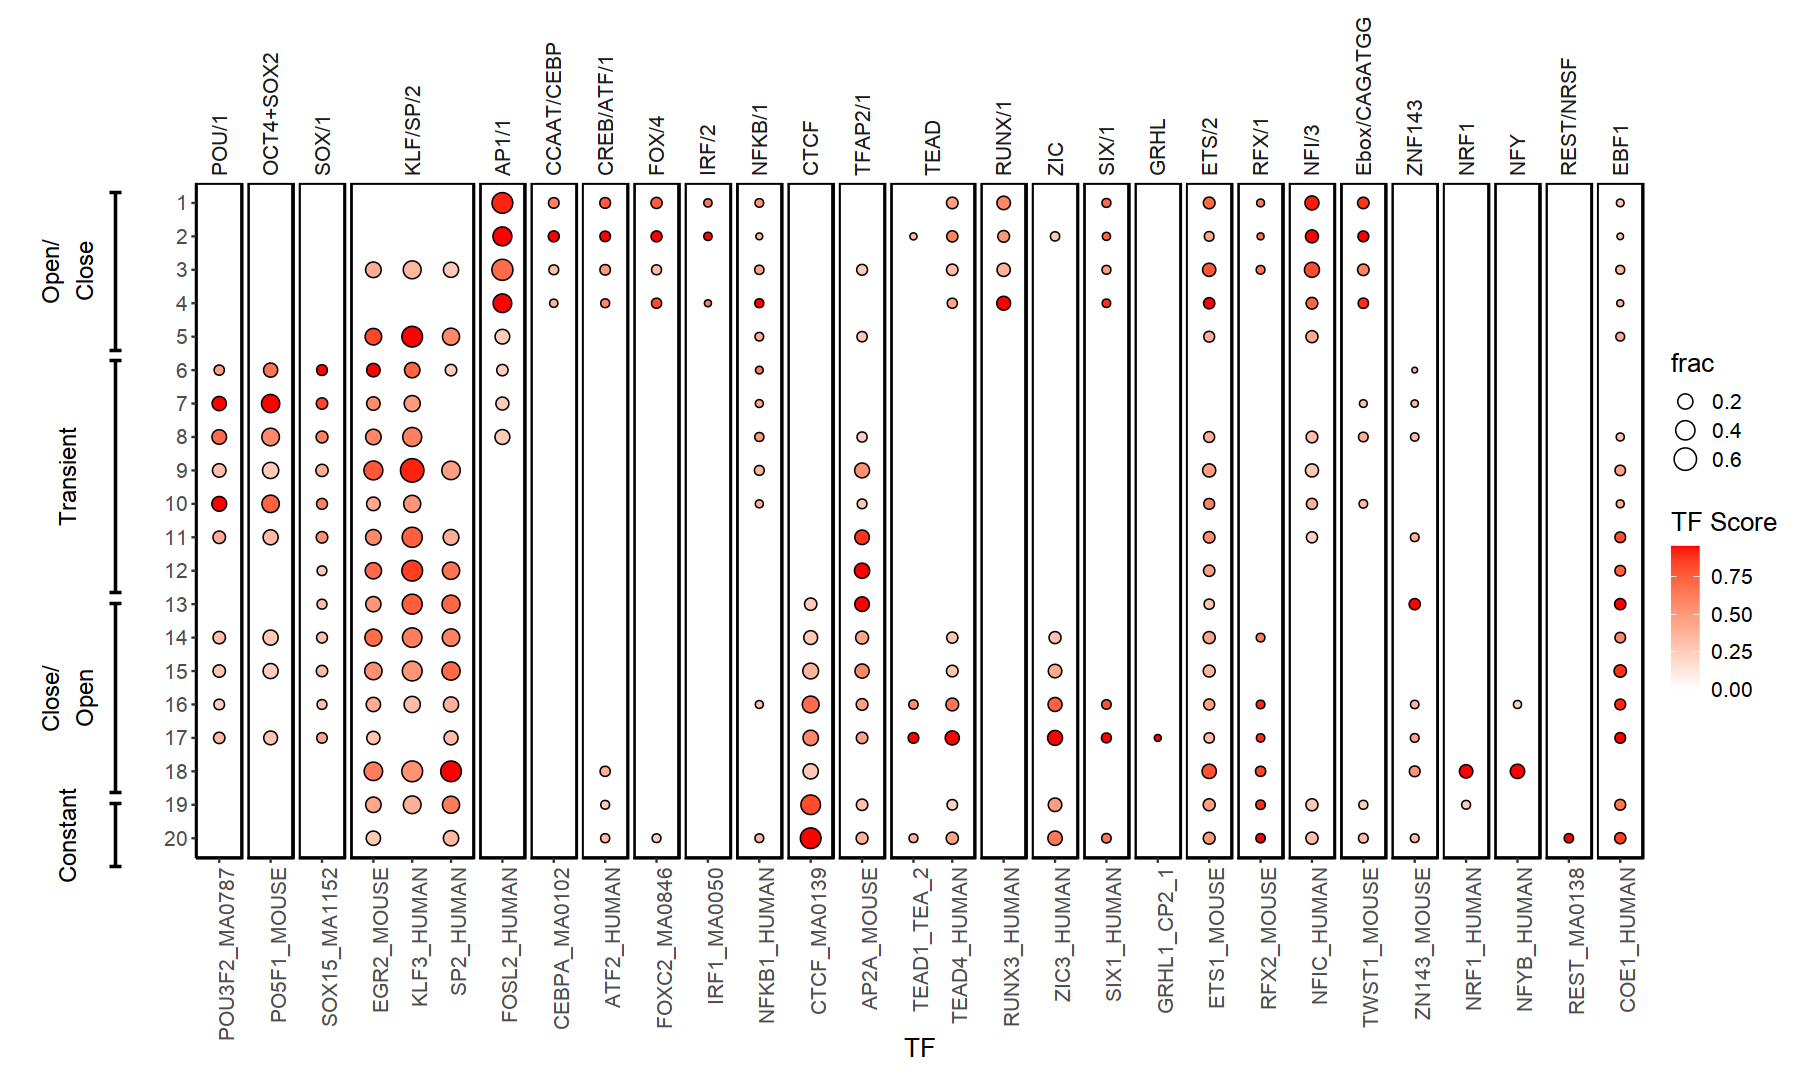

In [716]:
options(repr.plot.width = 15, repr.plot.height = 9)

annotated

In [627]:
# saveRDS(annotated, file=sprintf("./subfigs/%s_peaksets.rds",
#                                 format(Sys.Date(), "%Y%m%d")))

### Cluster motifs instead of by family

In [717]:
tf_score_mat = matrix(0, length(unique(to_plot_df$Var1)), length(unique(as.character(to_plot_df$Var2))))
rownames(tf_score_mat) = sort(unique(to_plot_df$Var1))
colnames(tf_score_mat) = unique(as.character(to_plot_df$Var2))

tf_frac_mat = matrix(0, length(unique(to_plot_df$Var1)), length(unique(as.character(to_plot_df$Var2))))
rownames(tf_frac_mat) = sort(unique(to_plot_df$Var1))
colnames(tf_frac_mat) = unique(as.character(to_plot_df$Var2))

In [718]:
for (i in seq(nrow(to_plot_df))) {
    tf_score_mat[to_plot_df$Var1[i], as.character(to_plot_df$Var2[i])] = to_plot_df$value[i]
    tf_frac_mat[to_plot_df$Var1[i], as.character(to_plot_df$Var2[i])] = to_plot_df$frac[i]
}

In [719]:
tf_hclust = hclust(dist(t(tf_score_mat), method = "euclidean"), method = "ward.D")
tf_dendro = as.dendrogram(tf_hclust)
tf_dendro = reorder(tf_dendro, colSums(tf_score_mat* seq(1,20))/colSums(tf_score_mat))
tf_order = as.hclust(tf_dendro)$order

In [722]:
tf_score_mat_ordered = tf_score_mat[, tf_order]
tf_frac_mat_ordered = tf_frac_mat[, tf_order]

In [723]:
colnames(tf_score_mat_ordered) = lapply(strsplit(colnames(tf_score_mat_ordered), "_"), "[[", 1)
colnames(tf_frac_mat_ordered) = lapply(strsplit(colnames(tf_frac_mat_ordered), "_"), "[[", 1)

In [724]:
# omit TFs
# tf_score_mat_ordered = tf_score_mat_ordered[,!grepl("USF", colnames(tf_score_mat_ordered))]

In [725]:
ordered_to_plot_df = melt(tf_score_mat_ordered)
ordered_to_plot_df$frac = melt(tf_frac_mat_ordered)$value
ordered_to_plot_df = ordered_to_plot_df[ordered_to_plot_df$value > quantile(ordered_to_plot_df$value[ordered_to_plot_df$value>0], .25), ]

In [726]:
p <- ggplot(ordered_to_plot_df) +
# geom_tile(aes(x=Var2, y=factor(Var1, levels=rev(seq(1,20))), fill=value)) +
geom_point(aes(x=Var2, y=factor(Var1, levels=rev(seq(1,20))), fill=value, size=frac), shape=21) +
scale_fill_gradient(low="white",
                      high="red",
                      limits=c(0.05, 0.95),
                      oob=squish,
                      name="TF Score") +
xlab("TF") +
ylab("") +
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95), # rotate TF text
      strip.background = element_blank(),
      panel.grid.major = element_blank(),
          text = element_text(size=15)) 

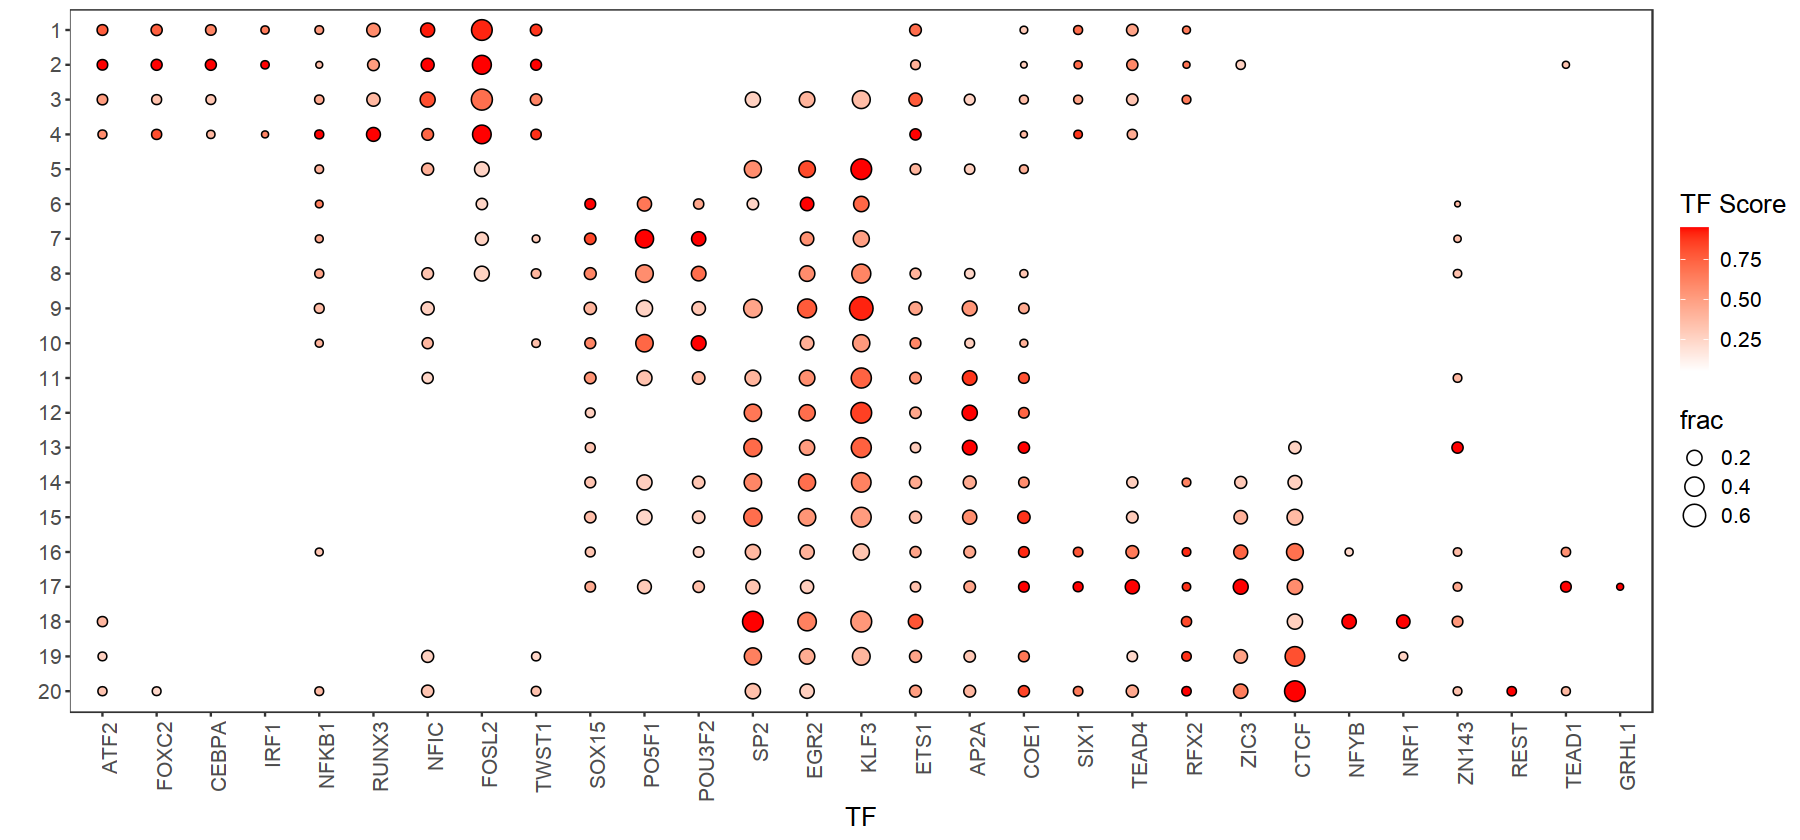

In [734]:
options(repr.plot.width = 15, repr.plot.height = 7)

p

In [735]:
ggsave("./subfigs/20211009_motif_matrix.pdf", p, width=15,height=7, useDingbats=F)

### OSK Ratios

In [704]:
osk_counts = peak_x_motif_counts[,grepl("PO|Sox|KLF3", colnames(peak_x_motif_counts), ignore.case = F)]
rownames(osk_counts) = sub('idx', '', rownames(osk_counts))
head(osk_counts)

,KLF3_HUMAN.H11MO.0.B,POU3F2_MA0787.1,PO5F1_MOUSE.H11MO.0.A
1,7937,1246,1738
2,5062,911,1559
3,10948,928,1508
4,3681,737,833
5,23753,547,907
6,8372,1665,5274


In [705]:
osk_frac_melted = melt(osk_counts/rowSums(osk_counts))
osk_frac_melted$Var1 = factor(osk_frac_melted$Var1, levels=sort(unique(osk_frac_melted$Var1)))

head(osk_frac_melted, 2)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,1,KLF3_HUMAN.H11MO.0.B,0.7267649
2,2,KLF3_HUMAN.H11MO.0.B,0.6720659


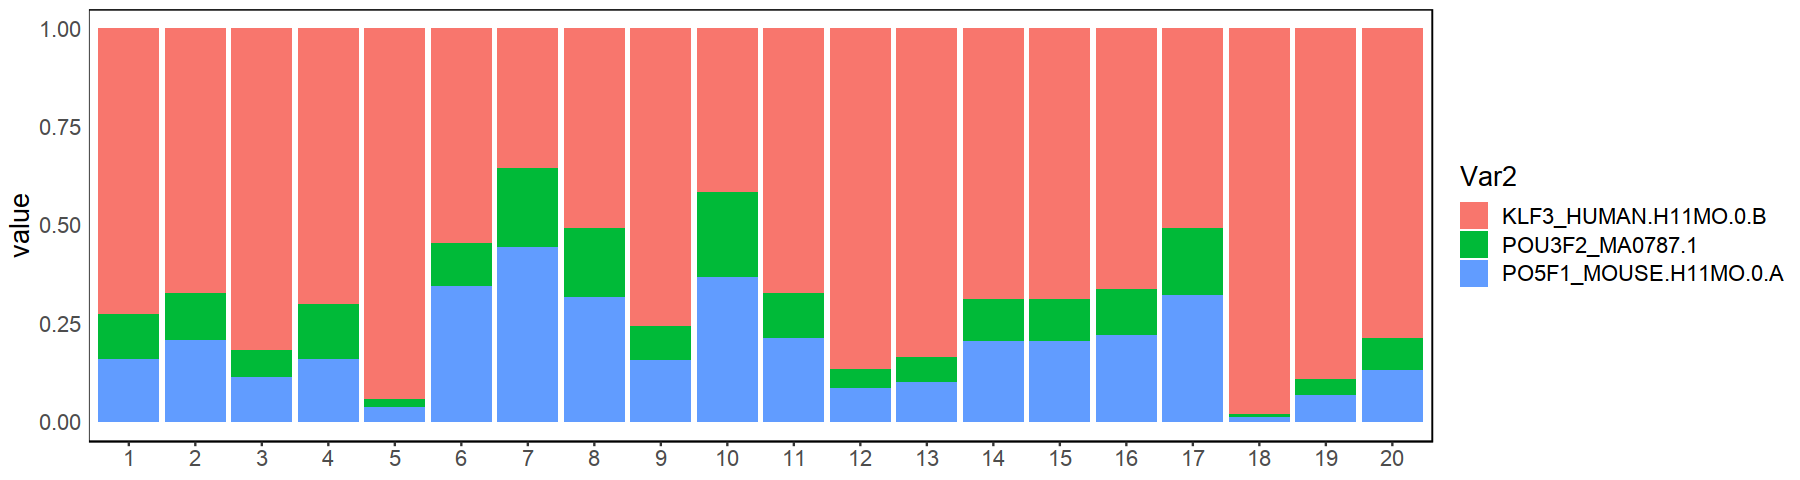

In [706]:
options(repr.plot.width = 15, repr.plot.height = 4)

ggplot(osk_frac_melted, aes(x=Var1, y=value, fill=Var2)) +
geom_bar(position='fill', stat='identity') +
theme_classic() +
theme(plot.title = element_text(hjust = 0.5),
    text = element_text(size=16),
    axis.line=element_blank(),
    axis.ticks.y=element_blank(),
    axis.title.x = element_blank(),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5))

---

In [707]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] patchwork_1.0.0      scales_1.1.0         ggplot2_3.3.3       
 [4] reshape2_1.4.4       matrixStats_0.56.0   rtracklayer_1.46.0  
 [7] GenomicRanges_1.38.0 GenomeInfoDb_1.22.1  IRanges_2.20.2      
[10] S4Vectors_0.24.4     BiocGenerics_0.32.0 

loaded via a namespace 